In [24]:
import numpy as np

In [25]:
class Soplo:
    #сюда я вынесла редко изменяемые параметры
    g = 1.2
    R = 363
    T_k = 3650
    phi_ras = 0.992
    
    def __init__(self, p_k, p_a, F_cr):
        #вводим сами
        self._p_k = p_k
        self._p_a = p_a
        self._F_cr = F_cr
        
        #само считается
        
        #параметры сопла
        self._R_cr = np.sqrt(F_cr / np.pi)
        self._r_skr = 0.45 * self._R_cr
        self._R_skr = 1.5 * self._R_cr
        self._theta_a = np.arccos(2 * self.phi_ras-1)
        self._F_a_ = ((((2/(self.g + 1)) ** (1/(self.g - 1))) * np.sqrt((self.g - 1)/(self.g + 1)))
                      / np.sqrt((p_a/p_k) ** (2/self.g) - (p_a/p_k) ** ((self.g + 1)/self.g)))#относительная площадь вых.сеч.
        self._F_a = self._F_a_ * self._F_cr#площадь на выходе
        self._R_a = np.sqrt(self._F_a / np.pi)#радиус на выходе
        self._rad_ratio = self._R_a/self._R_cr
        self._theta_m = 1
        self._length = 1
        #параметры начальных прямых. индекс cr - на скруглении крит.сеч., a - на вых. (обновляются по мере обращения к классу)
        self._k_cr = 1
        self._x_kas = 0
        self._b_cr = 1
        self._k_a = 0
        self._b_a = 0
        self._pt = 0
        
    def add_params_46(self, theta_m, lenrat):#добавляем параметры со страницы 46 и обновляем параметры геометрии
        self._theta_m = theta_m * np.pi / 180
        self._length = lenrat * self._R_cr
        #обновление значений
        self._k_cr = np.tan(self._theta_m)#угол наклона
        self._x_kas = self._k_cr * self._r_skr / np.sqrt(1 + self._k_cr **2)
        self._b_cr = self.rads(self._x_kas, self._r_skr) - self._x_kas * self._k_cr 
        self._k_a = - np.tan(self._theta_a)#угол наклона
        self._b_a =  np.tan(self._theta_a) * self._length + self._R_a
        self._pt = abs(self._b_a - self._b_cr) / abs(self._k_a - self._k_cr) #точка пересечения
    
    def rads(self, x, rad):#круг
        return -np.sqrt(rad**2-x**2)+self._R_cr+rad
    
    def line_kas(self, x):#касательная к скруглению в крит сеч.
        return(self._b_cr + self._k_cr * x)
    
    def line_ext(self, x):#прямая на выходе
        return(self._k_a * x + self._b_a)
    


In [26]:
s = Soplo(5.92, 0.059, 0.01)
print(s.__dict__)
s.add_params_46(28, 7.33)#добавляем параметры по графику
print('Основные параметры сопла и опорных прямых для построения сопла')
s.__dict__

{'_p_k': 5.92, '_p_a': 0.059, '_F_cr': 0.01, '_R_cr': 0.05641895835477563, '_r_skr': 0.025388531259649034, '_R_skr': 0.08462843753216345, '_theta_a': 0.17912481487888987, '_F_a_': 11.901661437014557, '_F_a': 0.11901661437014557, '_R_a': 0.19463854955825463, '_rad_ratio': 3.449878466991925, '_theta_m': 1, '_length': 1, '_k_cr': 1, '_x_kas': 0, '_b_cr': 1, '_k_a': 0, '_b_a': 0, '_pt': 0}
Основные параметры сопла и опорных прямых для построения сопла


{'_p_k': 5.92,
 '_p_a': 0.059,
 '_F_cr': 0.01,
 '_R_cr': 0.05641895835477563,
 '_r_skr': 0.025388531259649034,
 '_R_skr': 0.08462843753216345,
 '_theta_a': 0.17912481487888987,
 '_F_a_': 11.901661437014557,
 '_F_a': 0.11901661437014557,
 '_R_a': 0.19463854955825463,
 '_rad_ratio': 3.449878466991925,
 '_theta_m': 0.4886921905584123,
 '_length': 0.4135509647405054,
 '_k_cr': 0.5317094316614788,
 '_x_kas': 0.011919193447305871,
 '_b_cr': 0.053053199478763705,
 '_k_a': -0.18106550773430974,
 '_b_a': 0.26951836496300785,
 '_pt': 0.30369356934425795}

In [27]:
def returnlinear(x1, y1, x2, y2):#возвращает коэф. наклоная и смещение прямой по двум точкам
    a = (y2-y1)/(x2-x1)
    b = y1- x1 * (y2-y1)/(x2-x1)
    return a,b

def points_finder(n, X_cr, Y_cr, X_p, Y_p_cr, Y_p_a, X_a, Y_a):
    xs_cr = [i for i in X_cr + (X_p-X_cr)*np.arange(1, n)/n] #X координата опорной точки на левой прямой
    ys_cr = [s._k_cr* x + s._b_cr for x in xs_cr]#Y координата опорной точки на левой прямой

    xs_a = [i for i in X_p + (X_a-X_p)*np.arange(1, n)/n]#X координата опорной точки на правой прямой
    ys_a = [s._k_a* x + s._b_a for x in xs_a]#Y координата опорной точки на правой прямой
    

    #получаем параметры наклонных линий
    a_s, b_s = returnlinear(np.array(xs_cr), np.array(ys_cr),np.array(xs_a),np.array(ys_a))
    
    points_x = [X_cr]
    points_y = [Y_cr]
    #поиск самых низких точек пересечения множества вспомогательных прямых
    for i in range(len(a_s)-1):
        point_x = []
        point_y = []
        for j in range(i+1, len(a_s)):#массив точек пересечения с оставшимися прямыми для i-й прямой
            x = ((b_s[j]-b_s[i])/(a_s[i]-a_s[j]))
            point_x.append(x)
            y = a_s[i] * (b_s[j]-b_s[i])/(a_s[i]-a_s[j]) + b_s[i]
            point_y.append(y)
        #выбираем самую низкую точку
        points_x.append(point_x[point_y.index(min(point_y))])
        points_y.append(point_y[point_y.index(min(point_y))])  
        plt.plot([xs_cr[i],xs_a[i]] , [ys_cr[i],ys_a[i]],  linewidth=0.25, color='k' )
        
    points_x.append(X_a)
    points_y.append(Y_a)
    plt.axis('scaled')
    plt.show()
    
    return points_x, points_y


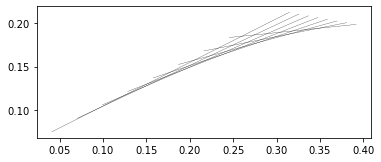

In [28]:
#координаты основных опорных точек: 
#касательная скруглению критического сечения на выходе
X_cr = s._x_kas
Y_cr = s._k_cr* X_cr+ s._b_cr
#точка пересечения
X_p = s._pt
Y_p_cr = s._k_cr* X_p + s._b_cr
Y_p_a = s._k_a * X_p + s._b_a
#крайняя точка на выходе сопла
X_a = s._length
Y_a = s._R_a
#количество опорных точек для построения
n = 10

points_x, points_y = points_finder(n, X_cr, Y_cr, X_p, Y_p_cr, Y_p_a, X_a, Y_a)


In [29]:
import matplotlib.pyplot as plt

#для вывода сопла единым массивом точек

x_do = list(np.linspace(-s._R_skr, 0, 100))
x = list(np.linspace(0, s._x_kas, 100))

X = x_do+x+points_x

Y = [s.rads(i, s._R_skr) for i in x_do] + [s.rads(i, s._r_skr) for i in x] + points_y

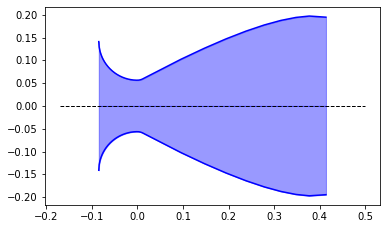

In [30]:
axis = np.linspace(-2*s._R_skr, s._length+s._R_skr, 10)#ось симметрии
plt.plot(axis , np.zeros(axis.shape[0]), '--', linewidth=1, color='k' )

#вспомогательные прямые под углами тета м и тета а
#x_line_kas = np.linspace(s._x_kas, s._pt, 100)
#x_line_a = np.linspace(s._pt, x_a, 100)
#plt.plot(x_line_kas, s.line_kas(x_line_kas))#касательная к радиусу скругления крит.сеч.
#plt.plot(x_line_a, s.line_ext(x_line_a))#на выходе

plt.fill_between(X, Y, alpha=0.4, color='b')
plt.plot(X, Y, color='b')

plt.fill_between(X, [-i for i in Y], alpha=0.4, color='b')
plt.plot(X, [-i for i in Y],'b')

plt.axis('scaled')
plt.show()
